Loaded 1700 SNe from Pantheon+SH0ES.dat (using zHD, mu-like=MU_SH0ES)

=== MODEL COMPARISON ===
LCDM:        χ²=745.3, dof=1698, χ²_red=0.439, AIC=749.3, BIC=760.2
Rough(accum): χ²=740.2, dof=1697, χ²_red=0.436, AIC=746.2, BIC=762.5
Template(1p): χ²=744.9, dof=1697, χ²_red=0.439, AIC=750.9, BIC=767.2
Δχ² (LCDM→Rough)    = 5.08 for -1 params
Δχ² (LCDM→Template) = 0.35 for -1 params
A (template) = -0.07999 ± 0.02343  [sqrtz_J ; Ωm_ref=1.0]

Saved figures: dmu_vs_chi.png, dmu_vs_zeta.png, template_* .png, overlay_*.png
Saved table  : bin_summary_zHD.csv


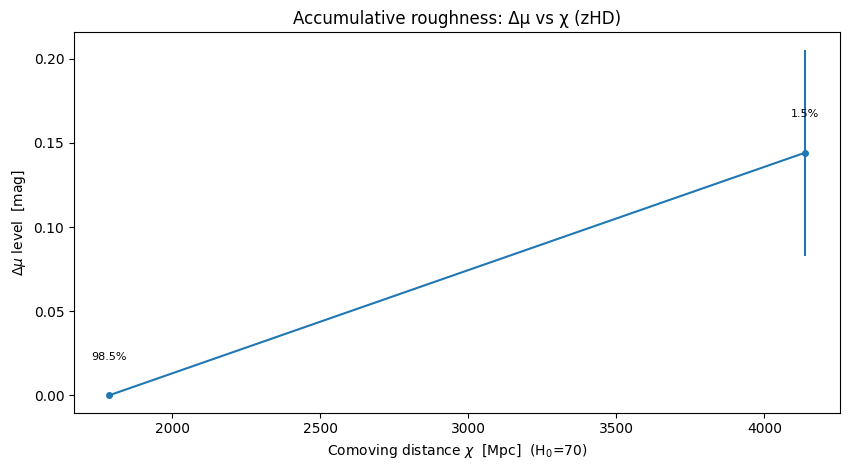

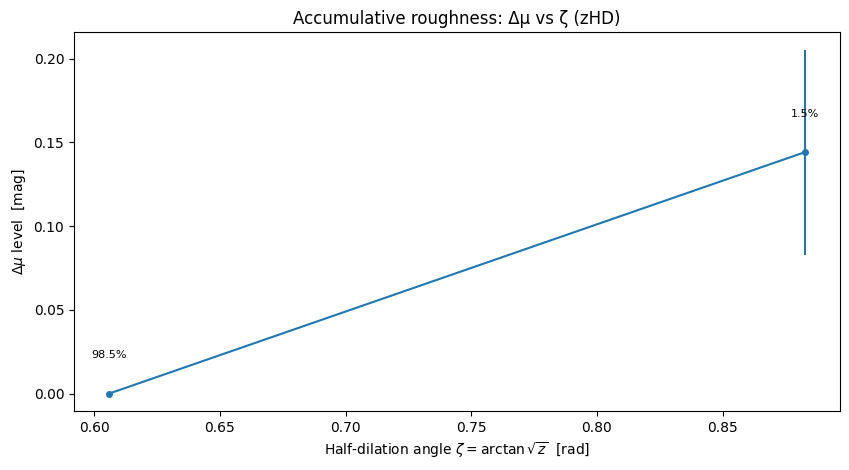

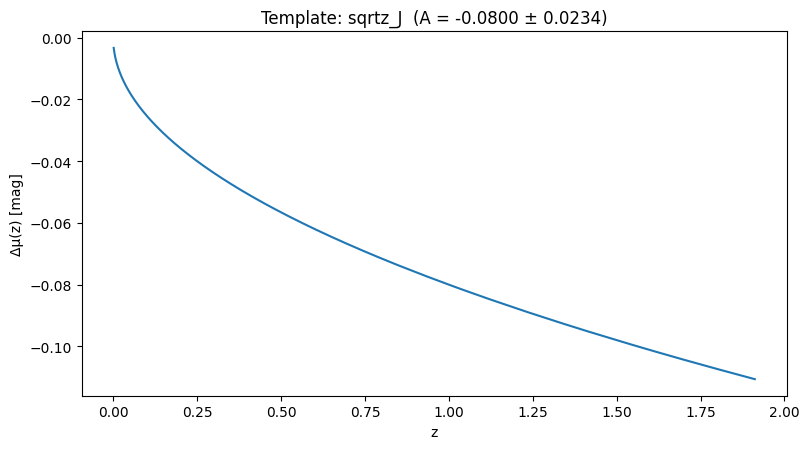

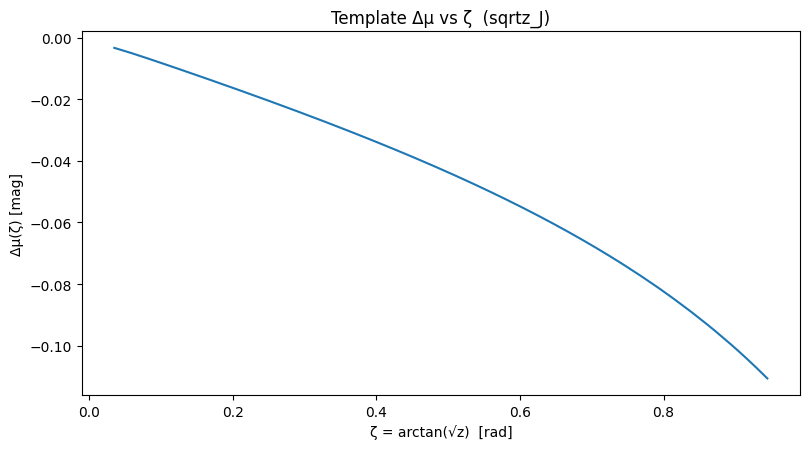

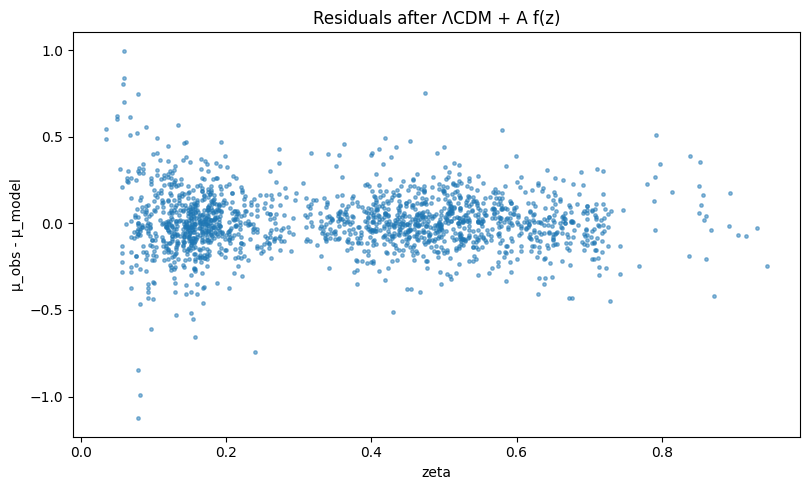

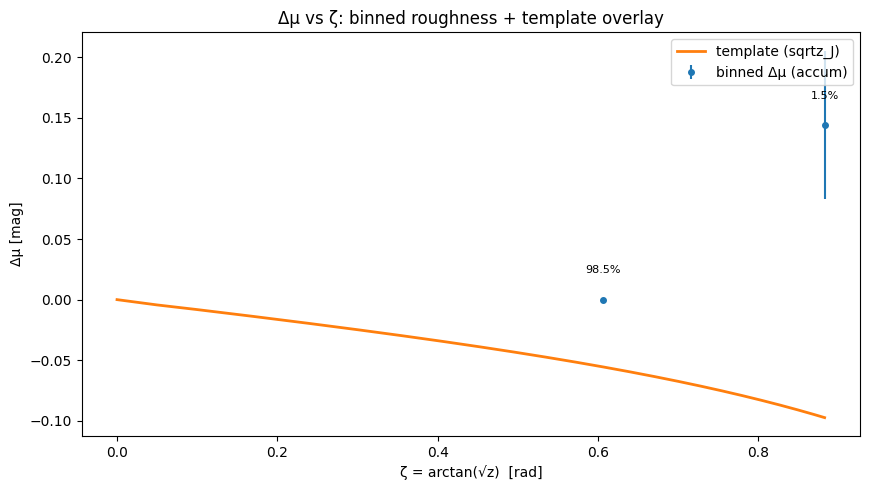

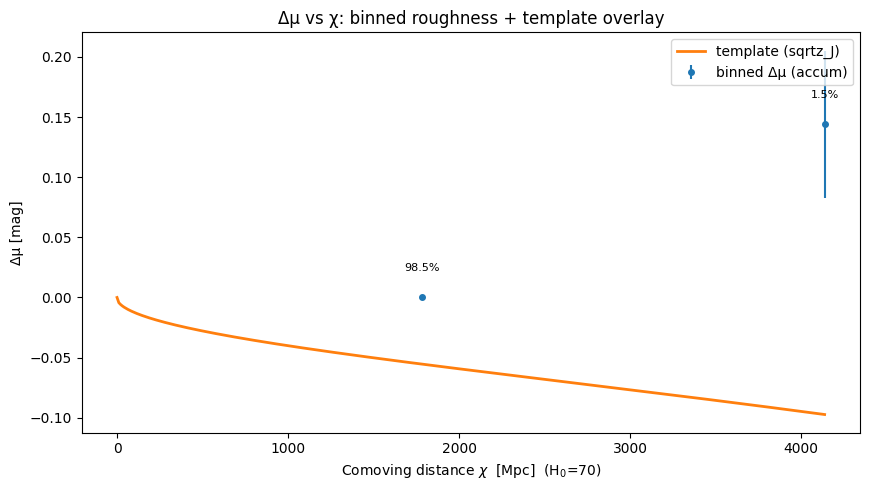

In [16]:
# pantheon_zHD_accum_check_v2.py
"""
Pantheon+ zHD — Accumulative Roughness Checker (v2)

Adds:
- 1-parameter *accumulative* template fit (choose TEMPLATE_KIND):
    * "sqrtz_J"   : f(z) = J(z; Ωm_ref) * sqrt(z)      [HD 'instant-turn' phenomenology]
    * "zeta_linear": f(z) = ζ(z) = arctan(sqrt(z))     [uniform in HD-angle]
    * "sec_linear" : f(z) = sqrt(1+z) - 1              [uniform in sec ζ]
    * "chi_linear" : f(z) ∝ χ(z; Ωm_ref) / max χ       [uniform in comoving distance]
- Model comparison: ΛCDM vs Rough(accum) vs Template(1p) with χ², dof, χ²_red, AIC, BIC.
- Overlay plots: template Δμ curve over binned roughness levels vs χ and vs ζ.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# ======= CONFIG =======
DATA_PATH = Path("./Pantheon+SH0ES.dat")
Z_BINS = np.array([0.0,0.96,2.0])
LAMBDA_SMOOTH = 1.0
SIGMA_FLOOR = 0.12
NINT = 10
H0 = 70.0
RIDGE = 1e-8

# Template settings
TEMPLATE_KIND  = "sqrtz_J"  # "sqrtz_J" | "zeta_linear" | "sec_linear" | "chi_linear"
TEMPLATE_OMREF = 1.0       # Ωm used in f(z) for "sqrtz_J" & "chi_linear"
# ======================

c_km_s = 299792.458
warnings.simplefilter("ignore", category=DeprecationWarning)

# --- HD angle & helpers ---
def z_to_zeta(z):
    z = np.asarray(z, float)
    return np.arctan(np.sqrt(np.clip(z, 0, None)))

# --- Loader (require zHD) ---
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)
    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}
    def pick_exact(name): return cols_lower.get(name.lower())

    zcol = pick_exact('zhd')
    if zcol is None: raise ValueError("This checker requires zHD column. Not found.")
    mucol  = (cols_lower.get('mu') or cols_lower.get('mu_sh0es') or
              cols_lower.get('distmod') or cols_lower.get('m_b_corr') or
              cols_lower.get('mb_corr') or cols_lower.get('mb'))
    sigcol = (cols_lower.get('mu_err') or cols_lower.get('sigma_mu') or
              cols_lower.get('mu_sh0es_err_diag') or cols_lower.get('m_b_corr_err_diag') or
              cols_lower.get('dmu') or cols_lower.get('dmb') or cols_lower.get('merr'))
    if mucol is None: raise ValueError("No mu-like column found.")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)
    out['sigma_mu'] = (df[sigcol].astype(float) if sigcol else SIGMA_FLOOR)
    out['sigma_mu'] = np.clip(out['sigma_mu'].values, SIGMA_FLOOR, None)
    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=0.0) & (out['z']<=2.0)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name} (using zHD, mu-like={mucol})")
    return out

# --- Cosmology ---
def E_z(z, Om): return np.sqrt(Om*(1+z)**3 + (1-Om))

def comoving_distance(z, Om, H0=H0):
    z = float(z)
    if z <= 0: return 0.0
    zg = np.linspace(0.0, z, NINT)
    Ez = E_z(zg, Om)
    return (c_km_s/H0) * np.trapezoid(1.0/Ez, zg)

def lum_distance(z, Om, H0=H0):
    return (1+z)*comoving_distance(z, Om, H0)

def mu_theory(z, Om, M):
    Dl = np.array([lum_distance(zi, Om) for zi in np.atleast_1d(z)])
    return 5.0*np.log10(np.clip(Dl,1e-9,None)) + M

# Sensitivity J(z; Om): ∂ ln D_L / ∂ ln(1+z)
def J_sensitivity(z, Om):
    z = np.asarray(z, float)
    Ez = E_z(z, Om)
    chi = np.array([comoving_distance(zi, Om, H0=H0) for zi in z])
    with np.errstate(divide='ignore', invalid='ignore'):
        J = 1.0 + (1.0 + z) / (Ez * np.where(chi>0, chi, np.inf))
    J[~np.isfinite(J)] = 1.0  # guard near z=0
    return J

# --- Baseline ΛCDM ---
def fit_lcdm(sn_df, Om_grid=np.linspace(0.05,0.6,200)):
    z = sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        M = np.sum(w*(y-mu0))/np.sum(w)
        r = y - (mu0 + M)
        chi2 = np.sum(w*r*r)
        if best is None or chi2<best['chi2']:
            best={'Om':float(Om),'M':float(M),'chi2':float(chi2)}
    N=len(y); k=2
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC']=best['chi2']+2*k; best['BIC']=best['chi2']+k*np.log(N)
    return best

# --- Design matrices ---
def design_matrix_bins(z, edges):
    B = np.zeros((len(z), len(edges)-1))
    for j in range(len(edges)-1):
        m = (z>=edges[j]) & (z<edges[j+1]); B[m,j]=1.0
    B[z>=edges[-1]-1e-10, -1]=1.0
    return B

def build_cumulative_steps(z, edges):
    z = np.asarray(z, float)
    Klev = len(edges)-1
    inner = edges[1:]
    zmax = np.max(z) if z.size>0 else -np.inf
    mask = inner <= (zmax + 1e-12)
    step_edges = inner[mask]
    Kc = len(step_edges)
    C = np.zeros((len(z), Kc))
    for m, thr in enumerate(step_edges):
        C[:, m] = (z >= thr).astype(float)
    T = np.zeros((Klev, Kc))
    for j in range(Klev):
        T[j, :min(j, Kc)] = 1.0
    return C, step_edges, T

# --- Accumulative roughness fit (robust) ---
def fit_lcdm_with_roughness_accum(sn_df, edges, lam=1.0, Om_grid=np.linspace(0.05,0.6,160)):
    z=sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    Klev = len(edges)-1
    C, step_edges, T = build_cumulative_steps(z, edges)
    Kc = C.shape[1]

    if Kc == 0:
        base = fit_lcdm(sn_df, Om_grid)
        base.update({'bin_edges':edges,'levels':np.zeros(Klev),'levels_err':np.zeros(Klev)})
        return base

    if Klev >= 3:
        D2 = np.zeros((Klev-2, Klev))
        for i in range(Klev-2): D2[i, i:i+3] = [1,-2,1]
        RtR_eps = T.T @ (D2.T @ D2) @ T
    else:
        RtR_eps = np.zeros((Kc, Kc))

    best=None; cov_theta_best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        X = np.column_stack([np.ones_like(y), C])
        W = np.diag(w)
        A = X.T @ W @ X
        b = X.T @ W @ (y - mu0)

        R = np.zeros_like(A); R[1:,1:] = lam * RtR_eps
        Areg = A + R
        Areg.flat[::Areg.shape[0]+1] += RIDGE * np.trace(Areg)/(Areg.shape[0])

        theta = np.linalg.solve(Areg, b)
        M = float(theta[0]); eps = theta[1:]
        resid = y - (mu0 + M + C @ eps)
        chi2 = float(np.sum(w*resid*resid) + lam * float(eps @ RtR_eps @ eps))

        if best is None or chi2<best['chi2']:
            best = {'Om':float(Om),'M':M,'eps':eps,'bin_edges':edges,'chi2':chi2}
            cov_theta_best = np.linalg.inv(Areg)

    levels = T @ best['eps']
    Ceps = cov_theta_best[1:,1:]; Cov_levels = T @ Ceps @ T.T
    levels_err = np.sqrt(np.clip(np.diag(Cov_levels), 0, None))

    N=len(y); k=2+Kc
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC']=best['chi2']+2*k; best['BIC']=best['chi2']+k*np.log(N)
    best['levels']=levels; best['levels_err']=levels_err
    return best

# --- 1-parameter accumulative template ---
def f_template(z, kind="sqrtz_J", Om_ref=0.30):
    z = np.asarray(z, float)
    if kind == "sqrtz_J":
        J = J_sensitivity(z, Om_ref)
        f = J * np.sqrt(np.clip(z, 0, None))
    elif kind == "zeta_linear":
        f = z_to_zeta(z)
    elif kind == "sec_linear":
        f = np.sqrt(1.0 + np.clip(z, 0, None)) - 1.0
    elif kind == "chi_linear":
        """
        zmax = float(np.max(z)) if np.size(z)>0 else 0.0
        def chi_one(zi): return comoving_distance(zi, Om_ref, H0=H0)
        chi_vals = np.array([chi_one(zi) for zi in z])
        chi_max  = chi_one(zmax) if zmax>0 else 1.0
        f = chi_vals / max(chi_max, 1e-9)
        """
        # Хабблова нормировка вместо "на максимум"
        f = np.array([comoving_distance(zi, Om_ref, H0=H0) for zi in z]) / (c_km_s/H0)
    else:
        raise ValueError(f"Unknown TEMPLATE_KIND: {kind}")
    return f

def fit_template(sn_df, kind="sqrtz_J", Om_ref=0.30, Om_grid=np.linspace(0.05,0.6,200)):
    z = sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    # БЫЛО
#    f_raw = f_template(z, kind=kind, Om_ref=Om_ref)
#    f_shift = np.average(f_raw, weights=w)
#    f = f_raw - f_shift
    # СТАЛО (якорим f(0)=0 и сохраняем накопление)
    f = f_template(z, kind=kind, Om_ref=Om_ref)
    f_shift = 0.0

    best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        X = np.column_stack([np.ones_like(z), f])  # M, A
        W = np.diag(w)
        A = X.T @ W @ X
        b = X.T @ W @ (y - mu0)
        theta = np.linalg.solve(A, b)
        Mhat, Ahat = float(theta[0]), float(theta[1])
        resid = y - (mu0 + Mhat + Ahat*f)
        chi2  = float(np.sum(w*resid*resid))
        if best is None or chi2 < best['chi2']:
            cov = np.linalg.inv(A)
            sigA = float(np.sqrt(cov[1,1]))
            best={'Om':float(Om),'M':Mhat,'A':Ahat,'sigma_A':sigA,'chi2':chi2,
                  'f':f,'f_shift':float(f_shift),'kind':kind,'Om_ref':Om_ref}
    N=len(y); k=3
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC']=best['chi2']+2*k; best['BIC']=best['chi2']+k*np.log(N)
    return best

# --- Plotters ---
def plot_binned(sn, lcdm, rough):
    z = sn['z'].values
    be = rough['bin_edges']
    B = design_matrix_bins(z, be)
    counts = B.sum(axis=0).astype(int); total=len(z); perc=counts/total*100.0
    zc = 0.5*(be[:-1]+be[1:])
    levels = rough['levels']; le = rough['levels_err']
    zeta_c = z_to_zeta(zc)
    chi_c = np.array([comoving_distance(zi, rough['Om'], H0=H0) for zi in zc])

    pd.DataFrame({
        "z_left":be[:-1],"z_right":be[1:],"count":counts,"percent":perc,
        "delta_mu_level":levels,"sigma_level":le,
        "chi_Mpc":chi_c,"zeta_rad":zeta_c
    }).to_csv("bin_summary_zHD.csv", index=False)

    plt.figure(figsize=(8.6,4.8))
    plt.errorbar(chi_c, levels, yerr=le, fmt='o-', ms=4)
    for j in range(len(counts)):
        plt.text(chi_c[j], (levels[j] if np.isfinite(levels[j]) else 0.0)+0.02,
                 f"{perc[j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel(r"Comoving distance $\chi$  [Mpc]  (H$_0$=%g)" % H0)
    plt.ylabel(r"$\Delta\mu$ level  [mag]")
    plt.title("Accumulative roughness: Δμ vs χ (zHD)")
    plt.tight_layout(); plt.savefig("dmu_vs_chi.png", dpi=160)

    plt.figure(figsize=(8.6,4.8))
    plt.errorbar(zeta_c, levels, yerr=le, fmt='o-', ms=4)
    for j in range(len(counts)):
        plt.text(zeta_c[j], (levels[j] if np.isfinite(levels[j]) else 0.0)+0.02,
                 f"{perc[j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel(r"Half-dilation angle $\zeta=\arctan\sqrt{z}$  [rad]")
    plt.ylabel(r"$\Delta\mu$ level  [mag]")
    plt.title("Accumulative roughness: Δμ vs ζ (zHD)")
    plt.tight_layout(); plt.savefig("dmu_vs_zeta.png", dpi=160)

    return {"zc":zc, "zeta_c":zeta_c, "chi_c":chi_c,
            "levels":levels, "le":le, "counts":counts, "perc":perc}

def plot_template_outputs(sn, templ, prefix="template"):
    z = sn['z'].values; y=sn['mu_like'].values
    f = templ['f']; dmu = templ['A']*f
    muT = mu_theory(z, templ['Om'], templ['M']) + dmu

    idx = np.argsort(z)
    plt.figure(figsize=(8.2,4.6))
    plt.plot(z[idx], dmu[idx])
    plt.xlabel("z"); plt.ylabel("Δμ(z) [mag]")
    plt.title(f"Template: {templ['kind']}  (A = {templ['A']:+.4f} ± {templ['sigma_A']:.4f})")
    plt.tight_layout(); plt.savefig(f"{prefix}_dmu.png", dpi=160)

    zeta = z_to_zeta(z); idx2 = np.argsort(zeta)
    plt.figure(figsize=(8.2,4.6))
    plt.plot(zeta[idx2], dmu[idx2])
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("Δμ(ζ) [mag]")
    plt.title(f"Template Δμ vs ζ  ({templ['kind']})")
    plt.tight_layout(); plt.savefig(f"{prefix}_dmu_vs_zeta.png", dpi=160)

    plt.figure(figsize=(8.2,5))
    plt.scatter(z_to_zeta(z), y - muT, s=6, alpha=0.5)
    plt.xlabel("zeta"); plt.ylabel("μ_obs - μ_model")
    plt.title("Residuals after ΛCDM + A f(z)")
    plt.tight_layout(); plt.savefig(f"{prefix}_resid.png", dpi=160)

def plot_overlays(bins, templ, Om_for_chi):
    z_max = float(np.max(bins["zc"])) if bins["zc"].size>0 else 0.0
    zg = np.linspace(0.0, z_max, 600)
    f_raw_grid = f_template(zg, kind=templ['kind'], Om_ref=templ['Om_ref'])
    f_grid = f_raw_grid - templ['f_shift']
    dmu_grid = templ['A'] * f_grid

    zeta_g = z_to_zeta(zg)
    chi_g  = np.array([comoving_distance(zi, Om_for_chi, H0=H0) for zi in zg])

    plt.figure(figsize=(8.8,5.0))
    plt.errorbar(bins["zeta_c"], bins["levels"], yerr=bins["le"], fmt='o', ms=4, label="binned Δμ (accum)")
    plt.plot(zeta_g, dmu_grid, lw=2, label=f"template ({templ['kind']})")
    for j,(x,y_) in enumerate(zip(bins["zeta_c"], bins["levels"])):
        plt.text(x, (y_ if np.isfinite(y_) else 0.0)+0.02, f"{bins['perc'][j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("Δμ [mag]")
    plt.title("Δμ vs ζ: binned roughness + template overlay")
    plt.legend(); plt.tight_layout(); plt.savefig("overlay_zeta.png", dpi=160)

    plt.figure(figsize=(8.8,5.0))
    plt.errorbar(bins["chi_c"], bins["levels"], yerr=bins["le"], fmt='o', ms=4, label="binned Δμ (accum)")
    plt.plot(chi_g, dmu_grid, lw=2, label=f"template ({templ['kind']})")
    for j,(x,y_) in enumerate(zip(bins["chi_c"], bins["levels"])):
        plt.text(x, (y_ if np.isfinite(y_) else 0.0)+0.02, f"{bins['perc'][j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel(r"Comoving distance $\chi$  [Mpc]  (H$_0$=%g)" % H0); plt.ylabel("Δμ [mag]")
    plt.title("Δμ vs χ: binned roughness + template overlay")
    plt.legend(); plt.tight_layout(); plt.savefig("overlay_chi.png", dpi=160)

# --- Main ---
def main():
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)
    rough = fit_lcdm_with_roughness_accum(sn, Z_BINS, LAMBDA_SMOOTH)
    templ = fit_template(sn, kind=TEMPLATE_KIND, Om_ref=TEMPLATE_OMREF)

    print("\n=== MODEL COMPARISON ===")
    print(f"LCDM:        χ²={lcdm['chi2']:.1f}, dof={lcdm['dof']}, χ²_red={lcdm['chi2_red']:.3f}, AIC={lcdm['AIC']:.1f}, BIC={lcdm['BIC']:.1f}")
    print(f"Rough(accum): χ²={rough['chi2']:.1f}, dof={rough['dof']}, χ²_red={rough['chi2_red']:.3f}, AIC={rough['AIC']:.1f}, BIC={rough['BIC']:.1f}")
    print(f"Template(1p): χ²={templ['chi2']:.1f}, dof={templ['dof']}, χ²_red={templ['chi2_red']:.3f}, AIC={templ['AIC']:.1f}, BIC={templ['BIC']:.1f}")
    print(f"Δχ² (LCDM→Rough)    = {lcdm['chi2']-rough['chi2']:.2f} for {rough['dof'] - lcdm['dof']:+d} params")
    print(f"Δχ² (LCDM→Template) = {lcdm['chi2']-templ['chi2']:.2f} for {templ['dof'] - lcdm['dof']:+d} params")
    print(f"A (template) = {templ['A']:+.5f} ± {templ['sigma_A']:.5f}  [{templ['kind']} ; Ωm_ref={templ['Om_ref']}]")

    bins = plot_binned(sn, lcdm, rough)
    plot_template_outputs(sn, templ, prefix=f"template_{templ['kind']}")
    plot_overlays(bins, templ, Om_for_chi=rough['Om'])

    print("\nSaved figures: dmu_vs_chi.png, dmu_vs_zeta.png, template_* .png, overlay_*.png")
    print("Saved table  : bin_summary_zHD.csv")

if __name__ == "__main__":
    main()


Loaded 1228 SNe from Pantheon+SH0ES.dat
Using z from 'zCMB', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'
Including peculiar-velocity error from 'VPECERR', z clip 0.003

=== RESULTS ===
z-min cut: 0.030, ADD_PEC_ERR=True, PREFER_ZHD=False
LCDM:   chi2=521.2, dof=1226, chi2_red=0.425, AIC=525.2, BIC=535.4
J√z (Ωm fixed to ΛCDM best-fit):
  Om=0.372,  A=-0.0052 ± 0.0296 mag
  chi2=521.2, dof=1225, chi2_red=0.425, AIC=527.2, BIC=542.5
Δχ² (ΛCDM→J√z) = 0.03 for -1 params
Saved: jsqrtz_template_dmu.png, jsqrtz_template_resid.png


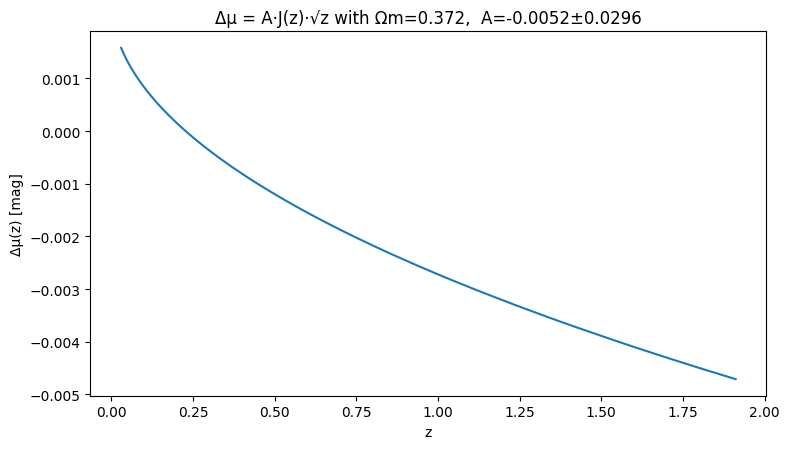

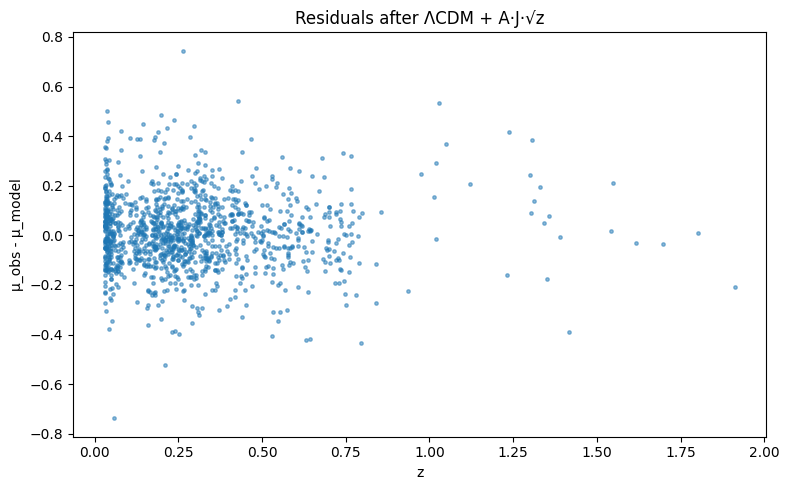

In [12]:
run unimetry_fit_jsqrtz.py


Config: OMEGA_K = -0.0500, Z_MIN = 0.030, FREEZE_OM_TO_LCDM = True
Loaded 1232 SNe from Pantheon+SH0ES.dat
Using z from 'zHD', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'
Including peculiar-velocity error from 'VPECERR', z clip 0.003

=== RESULTS ===
LCDM (Ωk=-0.050):  chi2=511.7, dof=1230, chi2_red=0.416, AIC=515.7, BIC=525.9
J√z (Ωm fixed to ΛCDM best-fit, Ωk=-0.050):
  Om=0.373,  A=+0.0037 ± 0.0055 mag
  chi2=511.3, dof=1229, chi2_red=0.416, AIC=517.3, BIC=532.6
Δχ² (ΛCDM → J√z) = 0.45 for -1 params
Saved: jsqrtz_curved_dmu.png, jsqrtz_curved_resid.png


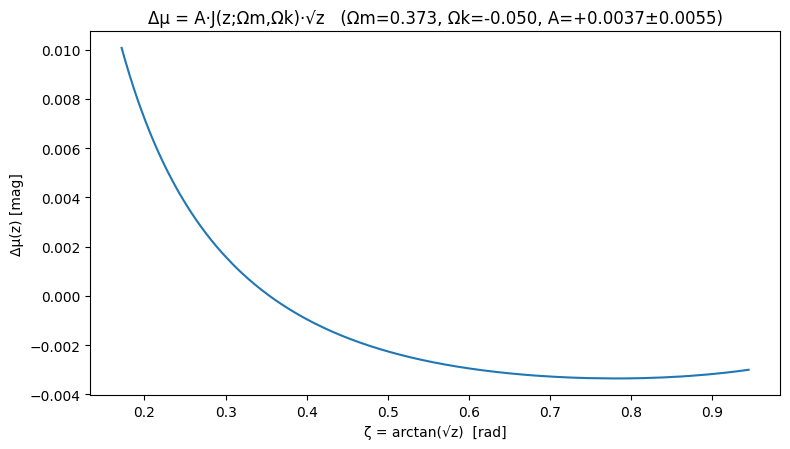

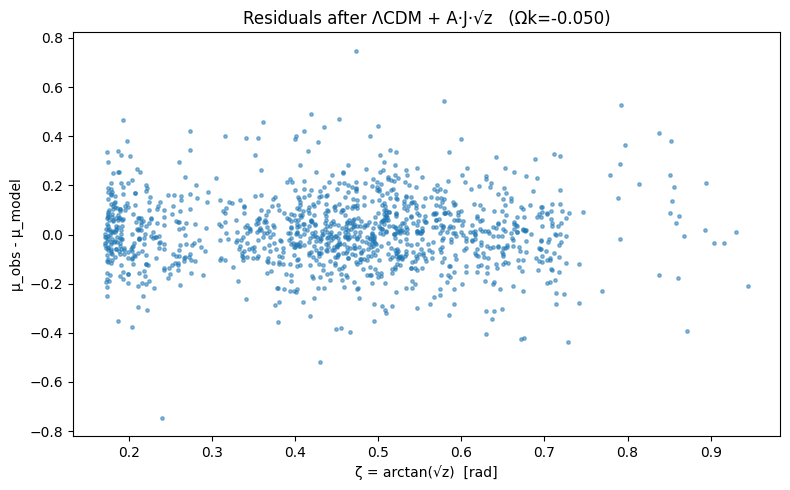

In [22]:
"""
Unimetry SN Fit — curvature-aware J(z; Ωm, Ωk) * √z template
(HD 'instant turn + immediate renormalization' phenomenology)

What this script does
---------------------
1) Loads Pantheon+SH0ES.dat (robust column autodetect).
2) Applies a low-z cut (to suppress peculiar-velocity systematics).
3) Baseline ΛCDM fit with curvature fixed to Ωk=OMEGA_K:
   - Fit Ωm on a grid, solve M analytically, keep ΩΛ = 1-Ωm-Ωk.
4) 1-parameter template fit Δμ(z) = A · f(z) with
   f(z) = J(z;Ωm,Ωk) · √z,  where
   J(z;Ωm,Ωk) = 1 + ((1+z)/E) * [S_k'(D_C)/S_k(D_C)],
   E^2 = Ωm(1+z)^3 + Ωk(1+z)^2 + ΩΛ,   D_C = ∫ dz/E.
   Two modes:
     (A) Ωm fixed to the baseline ΛCDM best-fit (FREEZE_OM_TO_LCDM=True)
     (B) Ωm refit jointly with A (grid over Ωm) (FREEZE_OM_TO_LCDM=False)
   f(z) is weighted-centered to remove degeneracy with M.
5) Prints χ², dof, χ²_red, AIC/BIC, Δχ² vs ΛCDM, A±σ(A).
6) Saves plots: Δμ(z) curve and residuals after ΛCDM+template.

Configuration
-------------
- Set OMEGA_K for curvature: 0 (flat), <0 (closed, 3-sphere), >0 (open).
- Tweak Z_MIN, PREFER_ZHD, ADD_PEC_ERR as needed.

Outputs
-------
- jsqrtz_curved_dmu.png
- jsqrtz_curved_resid.png

Run:
-----
python unimetry_fit_jsqrtz_curved.py
"""
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------- Config -----------------
DATA_PATH = Path("./Pantheon+SH0ES.dat")
Z_MIN = 0.03         # low-z cut (try 0.02–0.05)
PREFER_ZHD = True    # prefer zHD instead of zCMB
ADD_PEC_ERR = True   # add peculiar-velocity error if available
PEC_Z_CLIP = 0.003   # avoid blow-up at z~0 in σ_μ,pec
SIGMA_FLOOR = 0.12   # minimal σ_μ if missing

# Template fitting options
FREEZE_OM_TO_LCDM = True           # True: fix Ωm to baseline; False: refit with A
OM_GRID = np.linspace(0.05, 0.6, 241)
H0 = 70.0                          # km/s/Mpc (affects zero-point only via M)

# --- Curvature (FRW) ---
OMEGA_K = -0.05   # =0 flat, <0 closed (3-sphere), >0 open

SUPPRESS_WARNINGS = True
if SUPPRESS_WARNINGS:
    warnings.simplefilter("ignore", category=DeprecationWarning)

c_km_s = 299792.458
# --- HD angle & helpers ---
def z_to_zeta(z):
    z = np.asarray(z, float)
    return np.arctan(np.sqrt(np.clip(z, 0, None)))

# -------------- I/O helpers --------------
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)
    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            key = n.lower()
            if key in cols_lower:
                return cols_lower[key]
        return None

    # Choose z column
    if PREFER_ZHD:
        zcol = pick('zhd','zcmb','z')
    else:
        zcol = pick('zcmb','zhd','z')
    mucol  = pick('mu','mu_sh0es','distmod','m_b_corr','mb_corr','mb','m_b')
    sigcol = pick('mu_err','sigma_mu','mu_sh0es_err_diag','m_b_corr_err_diag','dmu','dmb','merr')
    vperr_col = pick('vpecerr','vpec_err','sigma_vpec')

    if zcol is None or mucol is None:
        raise ValueError(f"Missing essential columns. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)

    if sigcol is not None:
        out['sigma_mu'] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
        sigma_src = sigcol
    else:
        out['sigma_mu'] = SIGMA_FLOOR
        sigma_src = f"floor={SIGMA_FLOOR}"

    if ADD_PEC_ERR and (vperr_col is not None):
        zv = np.clip(out['z'].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr_col].astype(float).values
        sigma_mu_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out['sigma_mu'] = np.sqrt(out['sigma_mu'].values**2 + sigma_mu_pec**2)

    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=Z_MIN) & (out['z']<=2.0)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name}")
    print(f"Using z from '{zcol}', mu-like from '{mucol}', sigma from '{sigma_src}'")
    if ADD_PEC_ERR and (vperr_col is not None):
        print(f"Including peculiar-velocity error from '{vperr_col}', z clip {PEC_Z_CLIP}")
    return out

# --------- Cosmology with curvature ---------
def E_z(z, Om, Ok, Ol):
    """E(z) = H(z)/H0 for FRW with curvature (Ωk can be ±)."""
    z = np.asarray(z, float)
    return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)

def DC_dimless(z, Om, Ok, Ol, Nint=800):
    """Dimensionless line-of-sight comoving distance D_C = ∫0^z dz'/E(z')."""
    z = float(z)
    if z <= 0: return 0.0
    zg = np.linspace(0.0, z, Nint)
    Ez = E_z(zg, Om, Ok, Ol)
    return np.trapz(1.0/np.maximum(Ez, 1e-12), zg)

def S_k(x, Ok):
    """Transverse comoving kernel S_k(x) in dimensionless units."""
    if np.isclose(Ok, 0.0):
        return x
    s = np.sqrt(abs(Ok))
    if Ok > 0:
        return np.sinh(s*x)/s
    else:
        return np.sin(s*x)/s

def Skp_over_Sk(x, Ok):
    """Ratio S_k'(x)/S_k(x), stable for small x."""
    tiny = 1e-12
    if np.isclose(Ok, 0.0):
        return 1.0/max(x, tiny)
    s = np.sqrt(abs(Ok))
    sx = s*x
    if Ok > 0:
        return s*np.cosh(sx)/max(np.sinh(sx), tiny)  # s*coth(sx)
    else:
        return s*np.cos(sx)/max(np.sin(sx), tiny)    # s*cot(sx)

def lum_distance(z, Om, Ok, Ol, H0=H0):
    """
    D_L (Mpc) = (c/H0) * (1+z) * S_k(D_C),
    where D_C = ∫ dz/E (dimensionless), S_k — dimensionless kernel.
    """
    z = np.atleast_1d(z).astype(float)
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    DM = np.array([S_k(DCi, Ok) for DCi in DC])
    DL = (c_km_s/H0) * (1.0 + z) * DM  # Mpc
    return DL if DL.ndim else float(DL)

def mu_theory(z, Om, Ok, Ol, M0):
    Dl = lum_distance(z, Om, Ok, Ol, H0=H0)
    return 5.0*np.log10(np.clip(Dl, 1e-9, None)) + 25.0 + M0

def J_sensitivity(z, Om, Ok, Ol):
    """
    J = d ln D_L / d ln(1+z) = 1 + ((1+z)/E) * [S_k'(D_C)/S_k(D_C)],
    with D_C = ∫ dz/E — dimensionless.
    """
    z = np.asarray(z, float)
    Ez  = E_z(z, Om, Ok, Ol)
    DC  = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    ratio = np.array([Skp_over_Sk(DCi, Ok) for DCi in DC])  # S_k'/S_k
    with np.errstate(divide='ignore', invalid='ignore'):
        J = 1.0 + ((1.0+z)/np.maximum(Ez, 1e-12)) * ratio
    # Guard for z→0
    J[~np.isfinite(J)] = 2.0
    return J

# --------------- Baseline ΛCDM fit ---------------
def fit_lcdm(sn, Om_grid=OM_GRID):
    z = sn['z'].values
    y = sn['mu_like'].values
    w = 1.0/(sn['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        Ok = OMEGA_K
        Ol = 1.0 - Om - Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M = np.sum(w*(y-mu0))/np.sum(w)
        r = y - (mu0 + M)
        chi2 = np.sum(w*r*r)
        if best is None or chi2<best['chi2']:
            best={'Om':float(Om),'Ok':float(Ok),'Ol':float(Ol),'M':float(M),'chi2':float(chi2)}
    N = len(y); k = 2
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC'] = best['chi2'] + 2*k
    best['BIC'] = best['chi2'] + k*np.log(N)
    return best

# -------- Template fit: Δμ = A · J(z;Ωm,Ωk) · √z --------
def fit_jsqrtz(sn, Om_grid=OM_GRID, freeze_Om_to=None):
    z = sn['z'].values
    y = sn['mu_like'].values
    w = 1.0/(sn['sigma_mu'].values**2)
    best=None
    Om_list = [float(freeze_Om_to)] if (freeze_Om_to is not None) else Om_grid

    for Om in Om_list:
        Ok = OMEGA_K
        Ol = 1.0 - Om - Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)

        J  = J_sensitivity(z, Om, Ok, Ol)
        f  = J * np.sqrt(np.clip(z,0,None))
        f  = f - np.average(f, weights=w)  # weighted centering

        X = np.column_stack([np.ones_like(z), f])  # [M, A]
        W = np.diag(w)
        A_mat = X.T @ W @ X
        b_vec = X.T @ W @ (y - mu0)
        theta = np.linalg.solve(A_mat, b_vec)
        M_hat, A_hat = float(theta[0]), float(theta[1])

        resid = y - (mu0 + M_hat + A_hat*f)
        chi2  = float(np.sum(w*resid*resid))
        cov   = np.linalg.inv(A_mat)
        sigA  = float(np.sqrt(cov[1,1]))

        if (best is None) or (chi2<best['chi2']):
            best={'Om':float(Om),'Ok':float(Ok),'Ol':float(Ol),'M':M_hat,'A':A_hat,'sigma_A':sigA,
                  'chi2':chi2,'f':f,'resid':resid}

    N = len(y); k = 3  # counting [M, A, Ωm] effectively; Ωk fixed by config
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC'] = best['chi2'] + 2*k
    best['BIC'] = best['chi2'] + k*np.log(N)
    return best

# ------------------- Plots -------------------
def plot_jsqrtz(sn, lcdm, templ, prefix="jsqrtz_curved"):
    z = sn['z'].values; y = sn['mu_like'].values
    Om, Ok, Ol = templ['Om'], templ['Ok'], templ['Ol']

    J  = J_sensitivity(z, Om, Ok, Ol)
    f  = J * np.sqrt(np.clip(z,0,None))
    f  = f - np.average(f, weights=1.0/(sn['sigma_mu'].values**2))

    mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
    muT = mu0 + templ['M'] + templ['A']*f

    # Δμ(z)
    idx = np.argsort(z)
    plt.figure(figsize=(8,4.6))
    plt.plot(z_to_zeta(z[idx]), (templ['A']*f)[idx])
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("Δμ(z) [mag]")
    plt.title(f"Δμ = A·J(z;Ωm,Ωk)·√z   (Ωm={Om:.3f}, Ωk={Ok:+.3f}, A={templ['A']:+.4f}±{templ['sigma_A']:.4f})")
    plt.tight_layout(); plt.savefig(f"{prefix}_dmu.png", dpi=160)

    # Residuals after template
    plt.figure(figsize=(8,5))
    plt.scatter(z_to_zeta(z) , y - muT, s=6, alpha=0.5)
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("μ_obs - μ_model")
    plt.title(f"Residuals after ΛCDM + A·J·√z   (Ωk={Ok:+.3f})")
    plt.tight_layout(); plt.savefig(f"{prefix}_resid.png", dpi=160)

# -------------------- Main --------------------
def main():
    print(f"Config: OMEGA_K = {OMEGA_K:+.4f}, Z_MIN = {Z_MIN:.3f}, FREEZE_OM_TO_LCDM = {FREEZE_OM_TO_LCDM}")
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)

    if FREEZE_OM_TO_LCDM:
        templ = fit_jsqrtz(sn, freeze_Om_to=lcdm['Om'])
        mode = "Ωm fixed to ΛCDM best-fit"
    else:
        templ = fit_jsqrtz(sn)
        mode = "Ωm refit jointly with A"

    print("\n=== RESULTS ===")
    print(f"LCDM (Ωk={lcdm['Ok']:+.3f}):  chi2={lcdm['chi2']:.1f}, dof={lcdm['dof']}, chi2_red={lcdm['chi2_red']:.3f}, AIC={lcdm['AIC']:.1f}, BIC={lcdm['BIC']:.1f}")
    print(f"J√z ({mode}, Ωk={templ['Ok']:+.3f}):")
    print(f"  Om={templ['Om']:.3f},  A={templ['A']:+.4f} ± {templ['sigma_A']:.4f} mag")
    print(f"  chi2={templ['chi2']:.1f}, dof={templ['dof']}, chi2_red={templ['chi2_red']:.3f}, AIC={templ['AIC']:.1f}, BIC={templ['BIC']:.1f}")
    print(f"Δχ² (ΛCDM → J√z) = {lcdm['chi2']-templ['chi2']:.2f} for {templ['dof']-lcdm['dof']:+d} params")

    plot_jsqrtz(sn, lcdm, templ, prefix="jsqrtz_curved")
    print("Saved: jsqrtz_curved_dmu.png, jsqrtz_curved_resid.png")

if __name__ == "__main__":
    main()
